## IMPORTS

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from scipy.io import loadmat
#from scipy.signal import decimate, stft

In [4]:
from sklearn.preprocessing import RobustScaler

In [88]:
from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack

## LOAD DATA

In [ ]:
#data = loadmat("Patient_1_interictal_segment_0001.mat")
#interictal_segment_1 = data['interictal_segment_1'][0][0][0]

#mat files = original data at 5000 Hz

In [5]:
def load_full_series(subject=str, name=str, number_of_files=int):
    full_df = pd.read_csv(f'{subject}_csv/{name}_segment_1.csv')
    for index in range(2, number_of_files+1): 
        print("Processing file #", index)
        temp = pd.read_csv(f'{subject}_csv/{name}_segment_{index}.csv')
        #get length of dataframe and define segmentation factor
        
        temp = pd.DataFrame(scaler(temp)) #scale the data

        full_df = full_df.merge(temp,left_index=True, right_index=True)
        print(full_df.shape)
    
    return full_df

### Downsample (100x)

In [ ]:
#interictal_segment_1 = pd.DataFrame(decimate(decimate(interictal_segment_1,10),10))
#interictal_segment_2 = pd.DataFrame(decimate(decimate(interictal_segment_2,10),10))
#preictal_segment_1 = pd.DataFrame(decimate(decimate(preictal_segment_1,10),10))

#all downsampling was done through a script on the data

### Scale

In [9]:
def scaler(df):
    return RobustScaler().fit_transform(df)

## BASELINE: get statistics for all the data by segments of 1000 datapoints

In [29]:
def stats_array_1000_points(subject=str, name=str,  number_of_files=int):

    stats = [] #list to store the segment stats
    
    for index in range(1, number_of_files+1): 
        print("Processing file #", index)
        temp = pd.read_csv(f'{subject}_csv/{name}_segment_{index}.csv')
        #get length of dataframe and define segmentation factor
        idx = int(temp.iloc[0].shape[0]/(len(temp.iloc[0])/1000))
        # dividing by 30 --> 1000 datapoints segments

        temp = pd.DataFrame(scaler(temp)) #scale the data

        i = 0

        while i < temp.iloc[0].shape[0]:
            for x in range(temp.shape[0]):
                segment = temp.iloc[x][i:idx+i]
                stats.append([x, np.mean(segment), np.median(segment), np.std(segment), np.var(segment)])

            i = idx+i
    return stats

In [25]:
def plot_sensor(stats_list, index):  #index = electrode number
    mu = []
    med = []
    std = []
    var = []

    for i in stats_list:   #plot the stats for the first sensor
        if i[0] == index:
            mu.append(i[1])
            med.append(i[2])
            std.append(i[3])
            var.append(i[4])

    plt.figure(figsize=(20,15))
    plt.xlim(0, len(mu))
    plt.ylim(-1,1.5)
    plt.plot(mu, label='mean')
    plt.plot(med, label='median')
    plt.plot(std, label='standard deviation')
    plt.plot(var, label='variance')
    plt.legend()

### Interictal data

In [16]:
interictal_stats = stats_array_1000_points('Patient_1', 'interictal', 50)

Processing file # 1
Processing file # 2
Processing file # 3
Processing file # 4
Processing file # 5
Processing file # 6
Processing file # 7
Processing file # 8
Processing file # 9
Processing file # 10
Processing file # 11
Processing file # 12
Processing file # 13
Processing file # 14
Processing file # 15
Processing file # 16
Processing file # 17
Processing file # 18
Processing file # 19
Processing file # 20
Processing file # 21
Processing file # 22
Processing file # 23
Processing file # 24
Processing file # 25
Processing file # 26
Processing file # 27
Processing file # 28
Processing file # 29
Processing file # 30
Processing file # 31
Processing file # 32
Processing file # 33
Processing file # 34
Processing file # 35
Processing file # 36
Processing file # 37
Processing file # 38
Processing file # 39
Processing file # 40
Processing file # 41
Processing file # 42
Processing file # 43
Processing file # 44
Processing file # 45
Processing file # 46
Processing file # 47
Processing file # 48
P

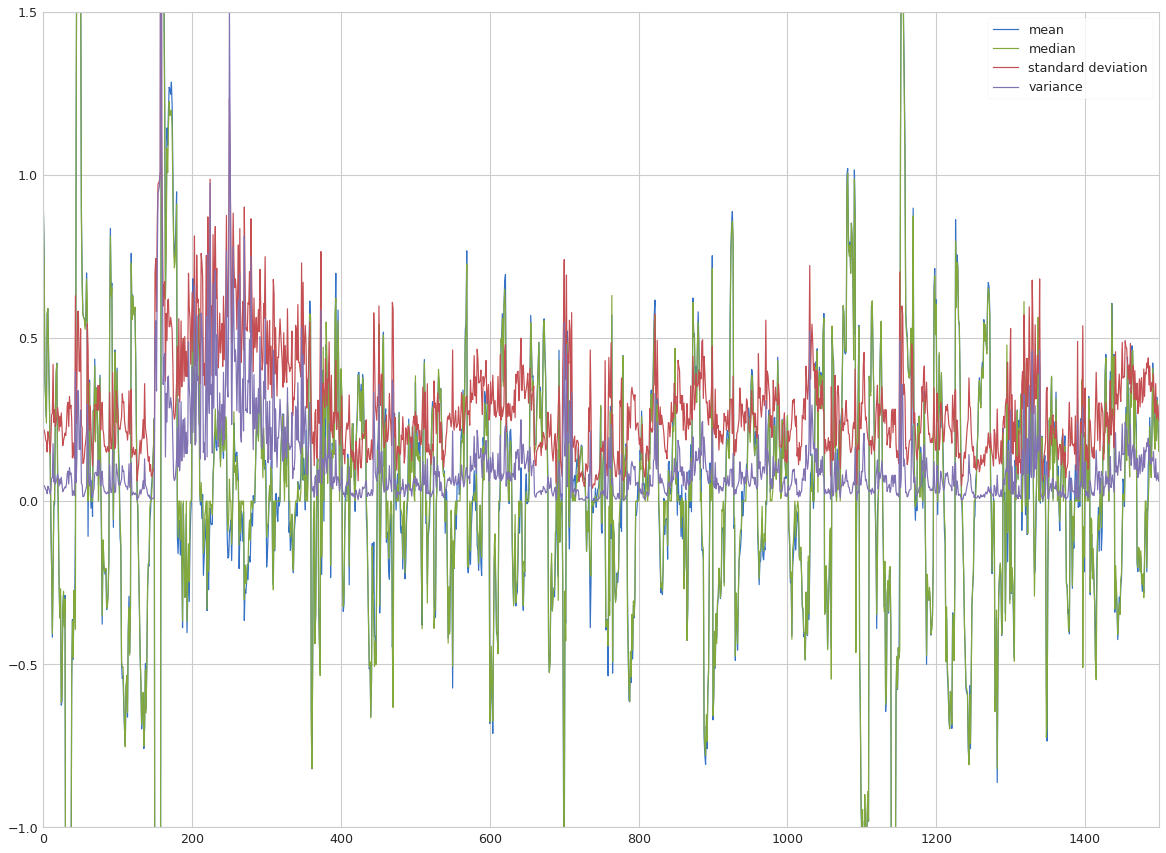

In [26]:
plot_sensor(interictal_stats, 8)

### Preictal data

In [30]:
preictal_stats = stats_array_1000_points('Patient_1', 'preictal', 18)

Processing file # 1
Processing file # 2
Processing file # 3
Processing file # 4
Processing file # 5
Processing file # 6
Processing file # 7
Processing file # 8
Processing file # 9
Processing file # 10
Processing file # 11
Processing file # 12
Processing file # 13
Processing file # 14
Processing file # 15
Processing file # 16
Processing file # 17
Processing file # 18


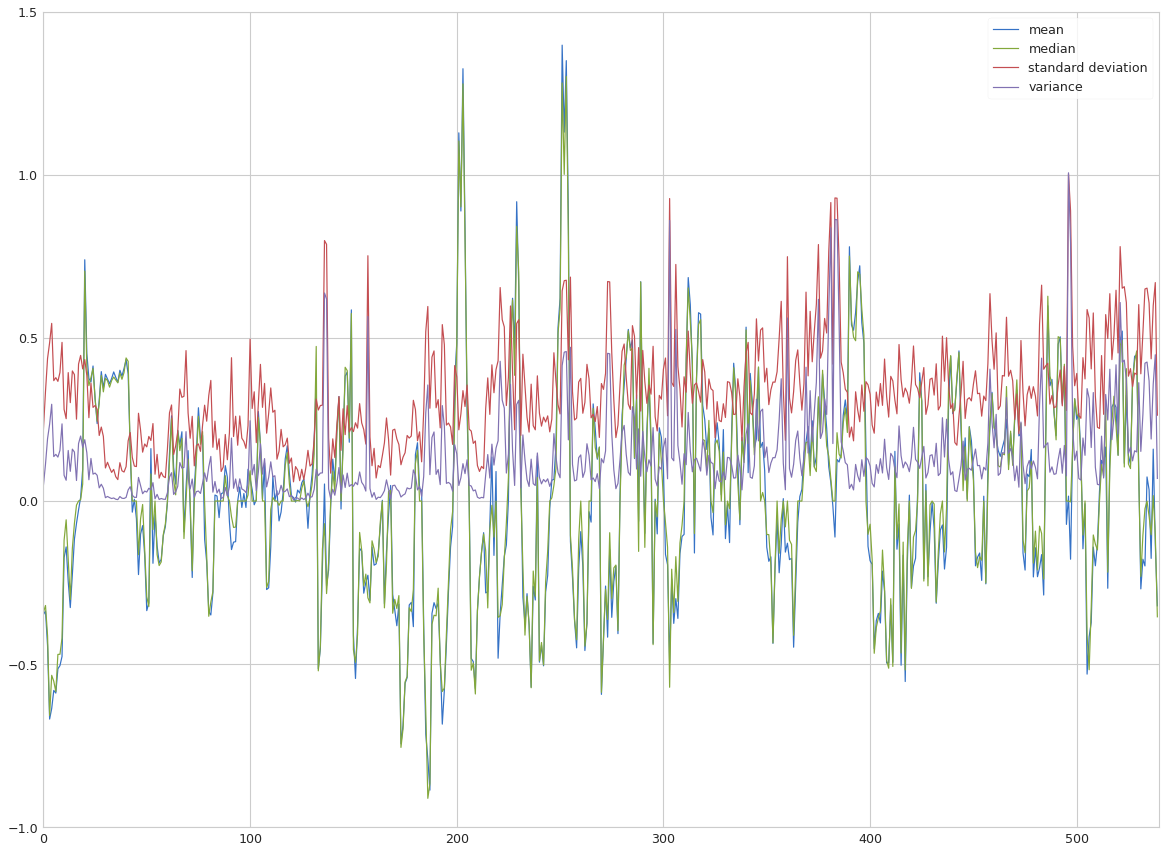

In [31]:
plot_sensor(preictal_stats, 8)

### Compare with the ictal dataset

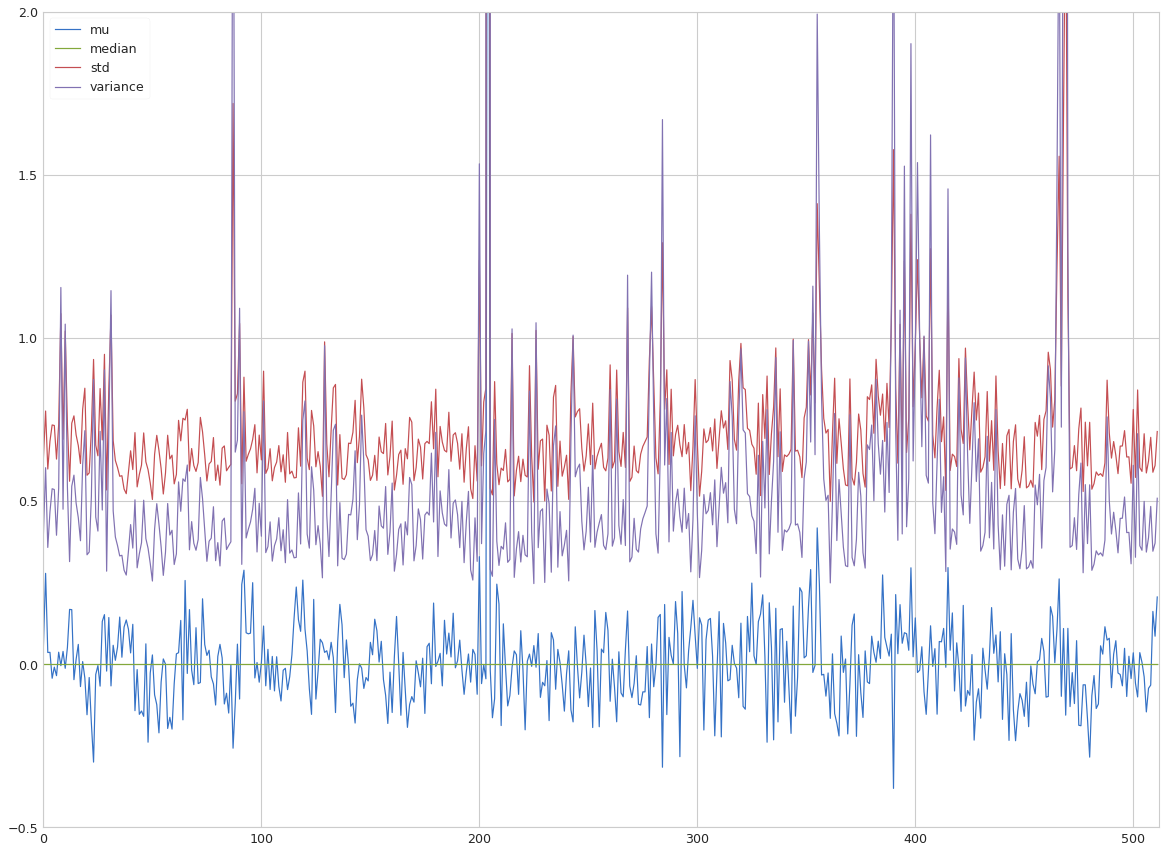

In [49]:
#An actual epilepsy crisis recording, just for comparing with the interictal & preictal data.

ictal = []
for i in range(1,51):
    ictal.append(loadmat(f"EEG_Epilepsy_Datasets/ictal/ictal{i}.mat")['ictal'])
ictal = np.reshape(ictal, -1)

idx = int(ictal.shape[0]/(len(ictal)/100))

ictal_stats = []
i = 0

while i < ictal.shape[0]:
    segment = ictal[i:idx+i]
    segment = scaler(segment.reshape(-1,1))
    ictal_stats.append([np.mean(segment), np.median(segment), np.std(segment), np.var(segment)])
    i = idx+i
    
mu = []
med = []
std = []
var = []

for i in ictal_stats:
        mu.append(i[0])
        med.append(i[1])
        std.append(i[2])
        var.append(i[3])

plt.figure(figsize=(20,15))
ax = plt.gca()
ax.set_xlim([0,len(ictal_stats)])
ax.set_ylim([-0.5,2])
plt.plot(mu, label='mu')
plt.plot(med, label='median')
plt.plot(std, label='std')
plt.plot(var, label='variance')
plt.legend()

### All the above = not useful

## Frequencies & Fourier Transform

### Functions

In [71]:
#Brain waves frequencies

def decompose_brainwaves(data):
    delta = (0,4)
    theta = (4.5,8)
    alpha = (8.5,12)
    beta = (12.5,35)
    gamma = (35, 200)

    frequencies = rfftfreq(data.size, d=1/data.size)

    fourier = rfft(data)
    
    output = []
    for i in (alpha, beta, delta, theta, gamma):
        #print(i)
        ft_threshed = fourier.copy()
        ft_threshed[(frequencies < i[0])] = 0
        ft_threshed[(frequencies > i[1])] = 0 
        output.append(irfft(ft_threshed))
    
    return output

def plot_brainwaves(data, subject=str):
    fig, axarr = plt.subplots(len(data), figsize=(20, 12))
    for i, signal in enumerate(data):
        plt.sca(axarr[i])
        plt.plot(signal)
    plt.gcf().suptitle(f"frequency bands: {subject} data", fontsize=24)
    

def plot_single_wave(data, label=str):
    plt.figure(figsize=(20,12))
    plt.xlim=(0,len(data))
    plt.ylim=(-0.75,0.75)
    sns.lineplot(data=data, label=label)
    plt.legend()
    plt.gcf().suptitle(f"Gamma band: {label}", fontsize=24)

In [159]:
#function for sorting the filelist by segment number

import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# I have no freaking idea how this works.

In [137]:
from os import path, walk

filelist = []

for root, dirs, files in walk('.'):
    for d in dirs:
        if 'Patient_1' in d:
            for root, dirs, files in walk(f'./{d}'):
                for f in files:
                    if 'interictal' in f:
                        filelist.append(f)

sort_nicely(filelist)

In [158]:
filelist

['interictal_segment_1.csv',
 'interictal_segment_2.csv',
 'interictal_segment_3.csv',
 'interictal_segment_4.csv',
 'interictal_segment_5.csv',
 'interictal_segment_6.csv',
 'interictal_segment_7.csv',
 'interictal_segment_8.csv',
 'interictal_segment_9.csv',
 'interictal_segment_10.csv',
 'interictal_segment_11.csv',
 'interictal_segment_12.csv',
 'interictal_segment_13.csv',
 'interictal_segment_14.csv',
 'interictal_segment_15.csv',
 'interictal_segment_16.csv',
 'interictal_segment_17.csv',
 'interictal_segment_18.csv',
 'interictal_segment_19.csv',
 'interictal_segment_20.csv',
 'interictal_segment_21.csv',
 'interictal_segment_22.csv',
 'interictal_segment_23.csv',
 'interictal_segment_24.csv',
 'interictal_segment_25.csv',
 'interictal_segment_26.csv',
 'interictal_segment_27.csv',
 'interictal_segment_28.csv',
 'interictal_segment_29.csv',
 'interictal_segment_30.csv',
 'interictal_segment_31.csv',
 'interictal_segment_32.csv',
 'interictal_segment_33.csv',
 'interictal_segmen

In [ ]:
def plot_variance_evolution(subject=str, name=str,  number_of_files=int):
    

#### Demo : frequency bands

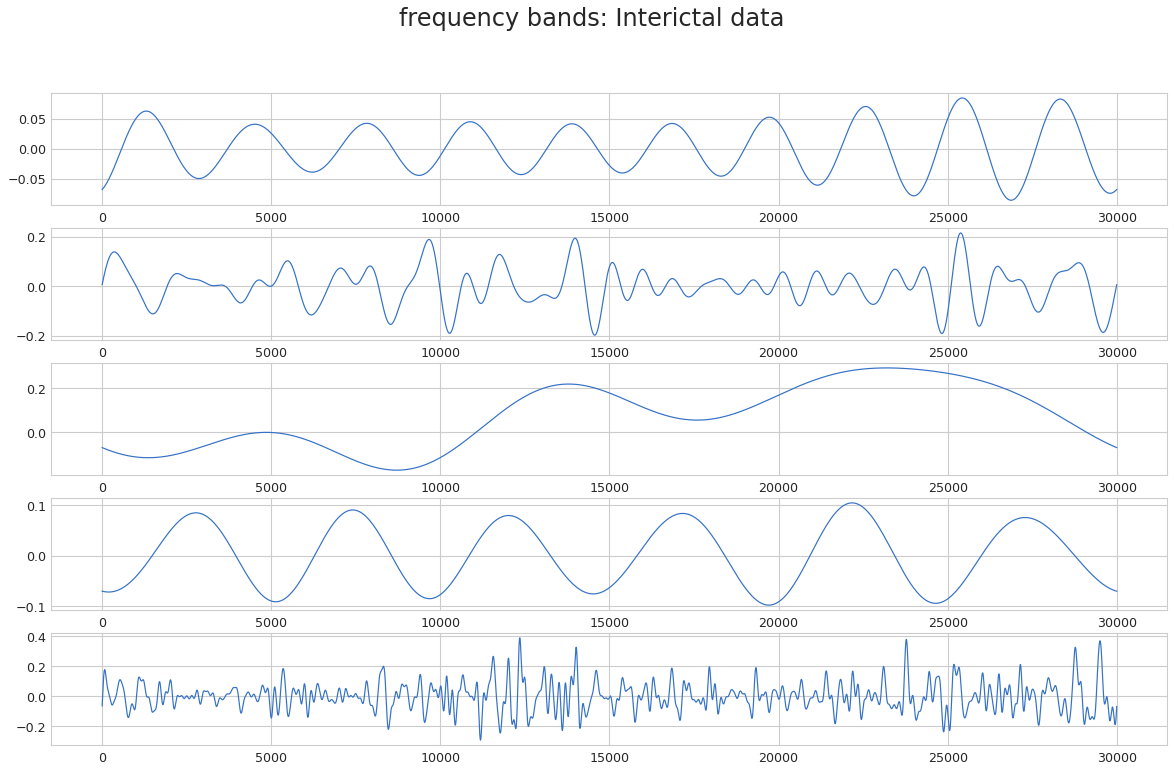

In [67]:
demo = pd.read_csv('Patient_1_csv/interictal_segment_15.csv')
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(demo)).iloc[0]), 'Interictal')                   

<br>
<center><b style="color:blue; font-size:24px">Only the last band seems useful<b><center>
<br>

### Comparing last preictal segment with the first one

In [61]:
interictal_segment_first = pd.read_csv('Patient_1_csv/interictal_segment_1.csv')

In [76]:
temp = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_first)).iloc[0])
temp1 = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0])
temp2 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_first)).iloc[0])
temp3 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0])

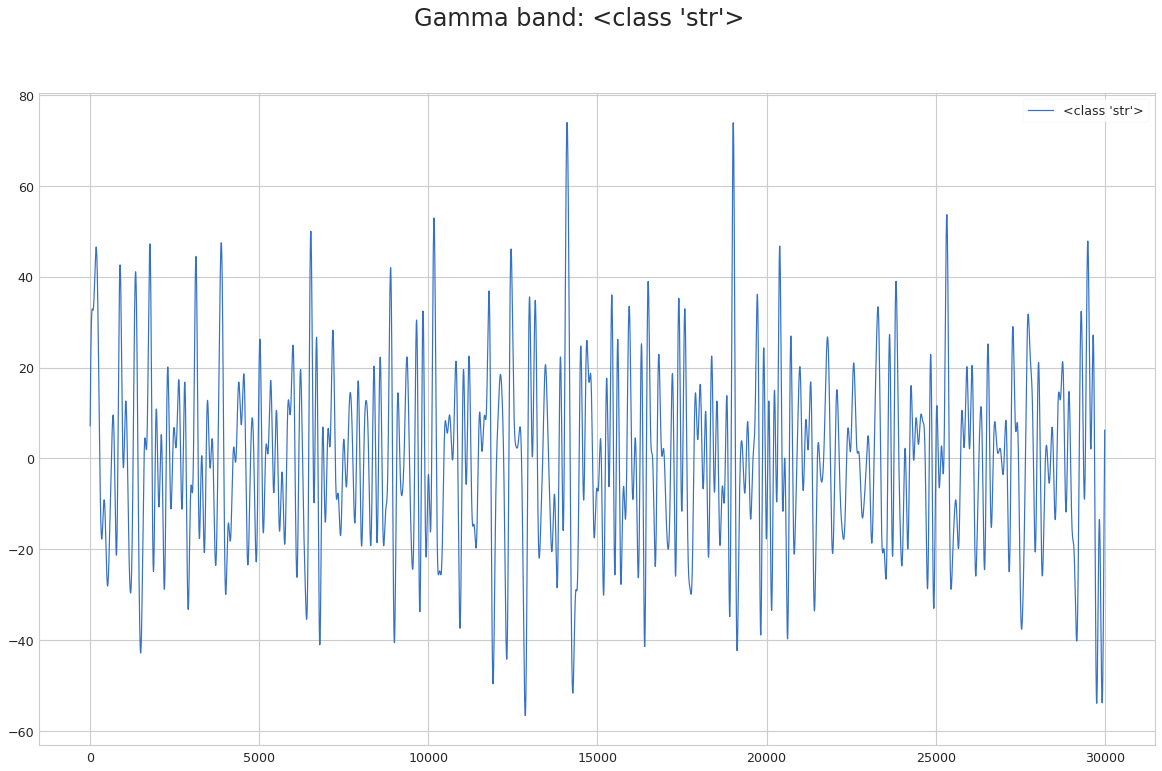

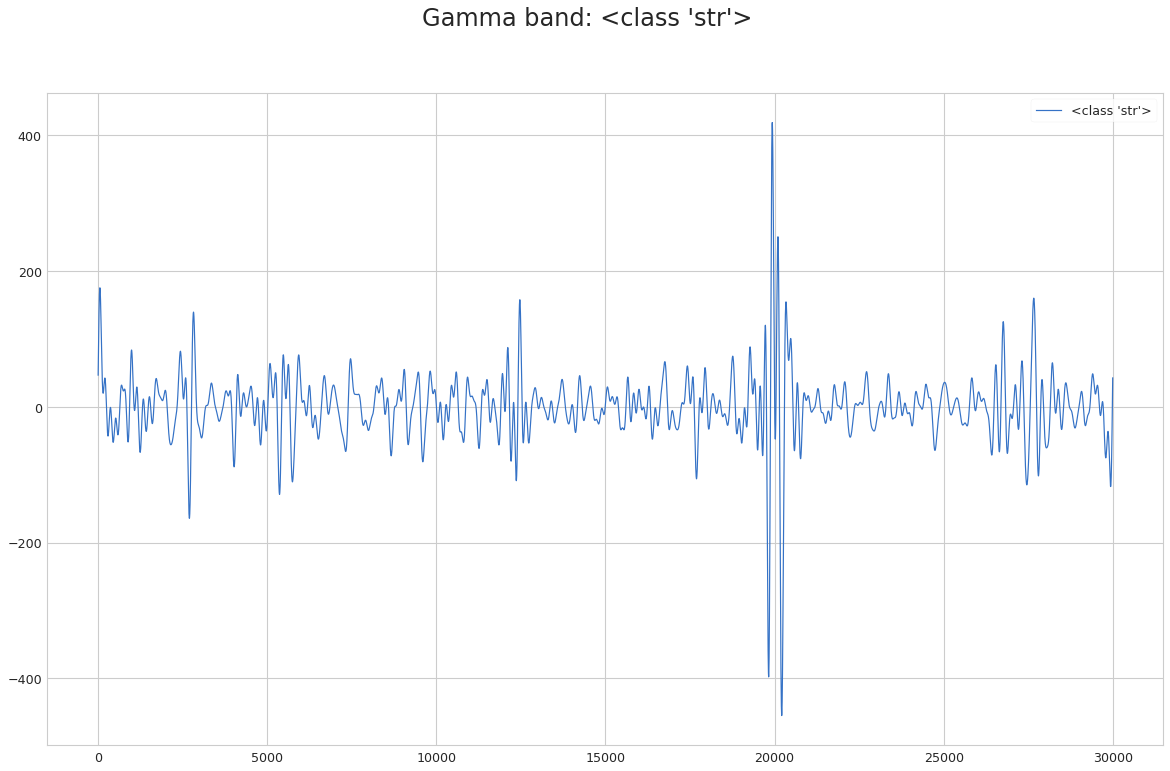

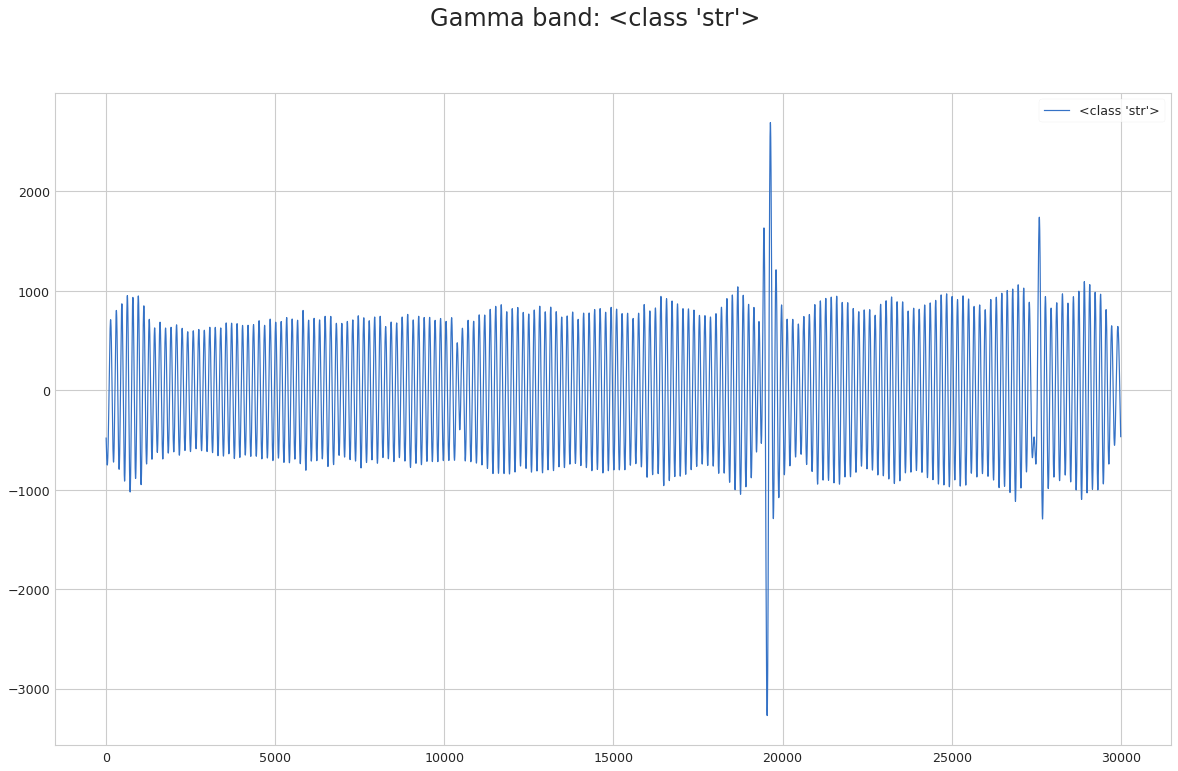

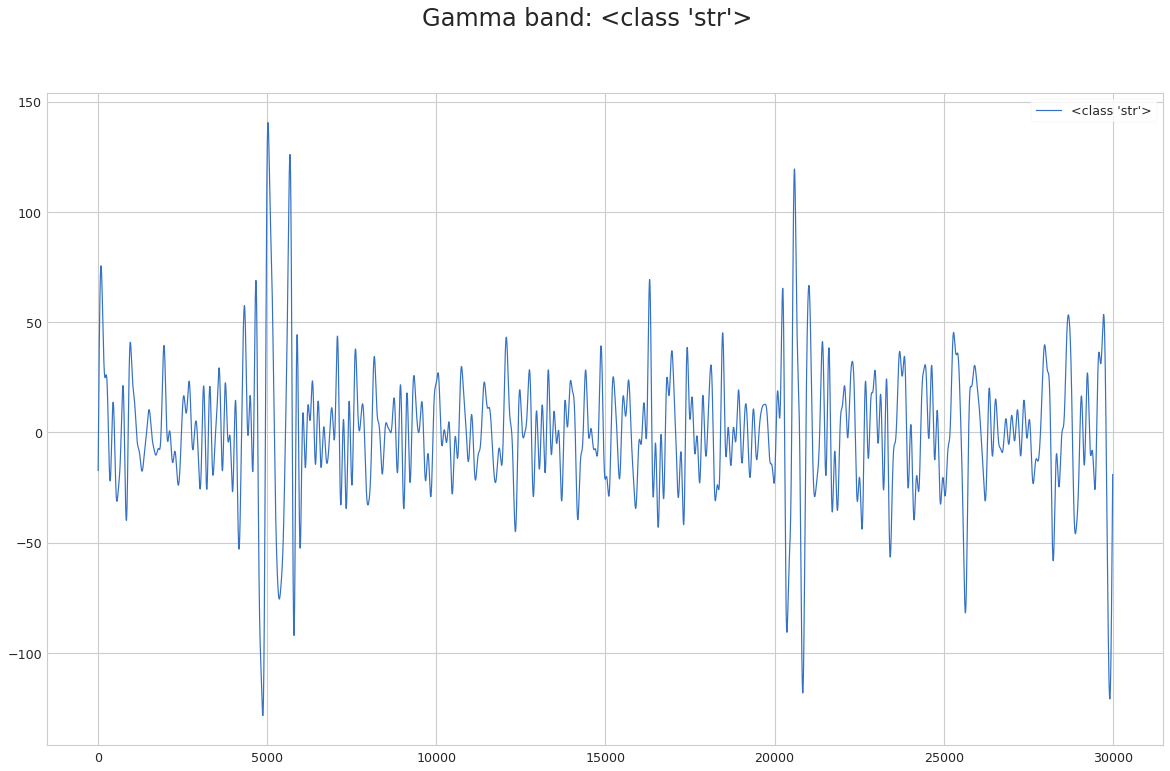

In [77]:
plot_single_wave(temp[4])
plot_single_wave(temp1[4])
plot_single_wave(temp2[4])
plot_single_wave(temp3[4])

In [65]:
interictal_segment_last = pd.read_csv('Patient_1_csv/interictal_segment_45.csv') #actually 45th out of 50

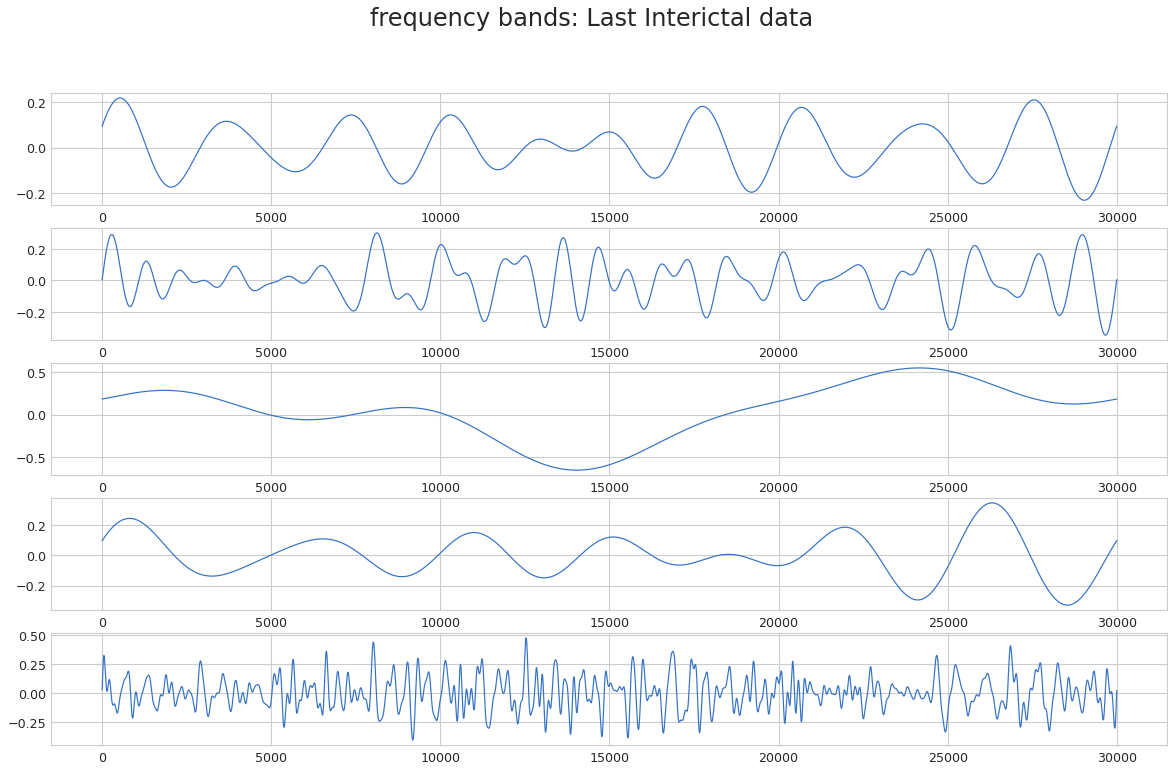

In [66]:
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0]), 'Last Interictal')                   

In [53]:
preictal_segment_first = pd.read_csv('Patient_1_csv/preictal_segment_1.csv')

In [59]:
preictal_segment_last = pd.read_csv('Patient_1_csv/preictal_segment_18.csv')

TypeError: 'NoneType' object is not subscriptable

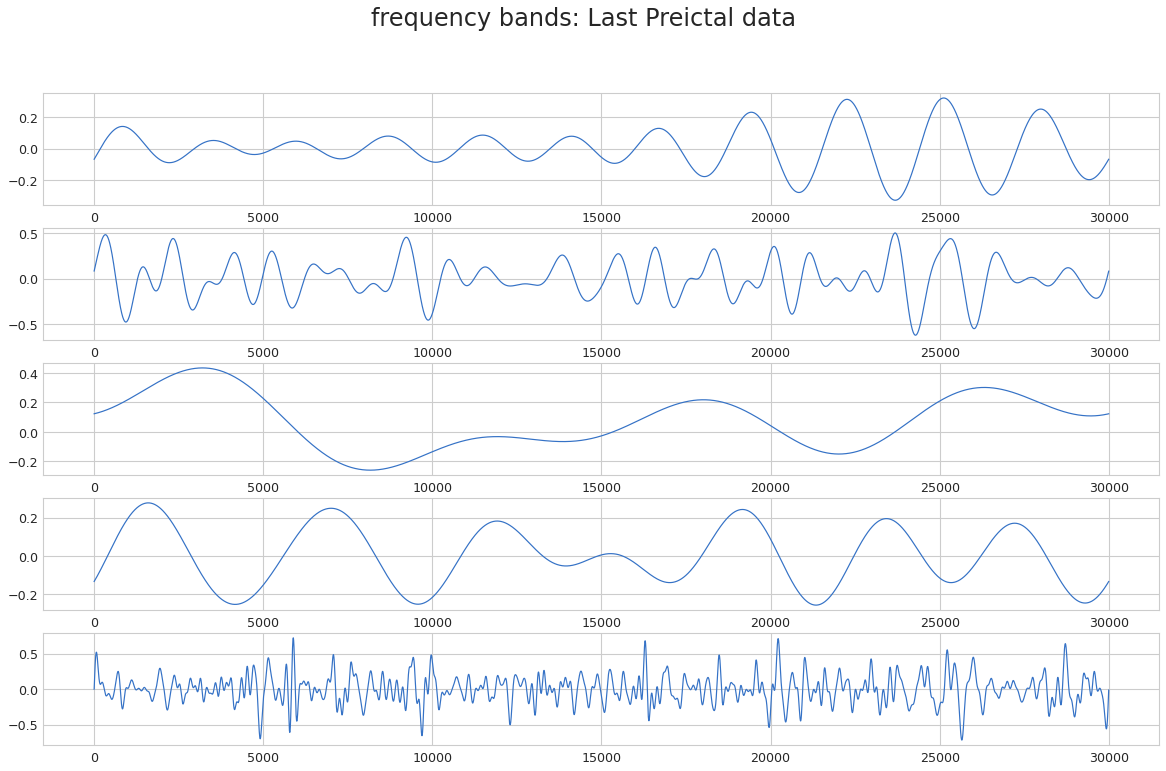

In [64]:
plot_brainwaves(decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0]), 'Last Preictal')                   

In [83]:
temp = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_first)).iloc[0])

In [84]:
temp1 = decompose_brainwaves(pd.DataFrame(scaler(interictal_segment_last)).iloc[0])

In [85]:
temp2 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_first)).iloc[0])

In [86]:
temp3 = decompose_brainwaves(pd.DataFrame(scaler(preictal_segment_last)).iloc[0])

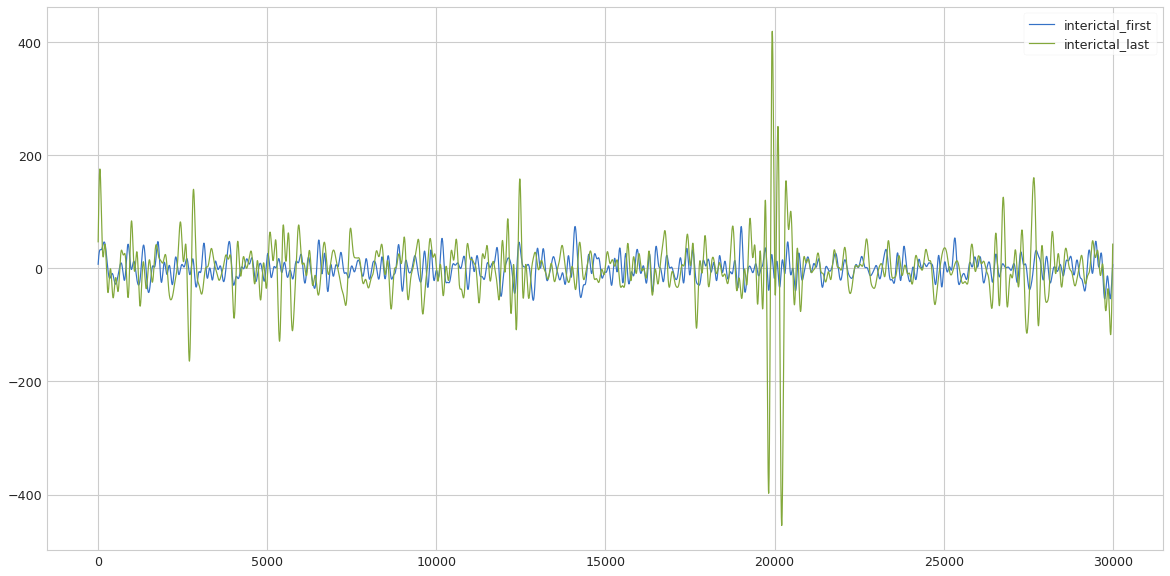

In [81]:
plt.figure(figsize=(20,10))
plt.xlim=(0,len(temp[4]))
plt.ylim=(-0.75,0.75)
sns.lineplot(data=temp[4], label='interictal_first')
sns.lineplot(data=temp1[4], label='interictal_last')
#sns.lineplot(data=temp2[4], label='preictal_first')
#sns.lineplot(data=temp3[4], label='preictal_last')
plt.legend()

In [87]:
print('Interical first variance:', np.var(temp[4]))
print('Interical last variance:', np.var(temp1[4]))
print('Preictal first variance:', np.var(temp2[4]))
print('Preictal last variance:', np.var(temp3[4]))


Interical first variance: 0.017857378253213756
Interical last variance: 0.019803492084595937
Preictal first variance: 0.010025506640992839
Preictal last variance: 0.03867125256191734


## CONVERTING THE FREQUENCIES INTO SOUND ?

In [ ]:
import librosa
from librosa import display

In [ ]:
from IPython.display import Audio

In [ ]:
samples, sampling_rate = librosa.load('test.wav', 
                                      sr=None, mono=True, offset=0.0, duration=None)

In [ ]:
plt.figure(figsize=(20,15))
librosa.display.waveplot(y=np.array(interictal_segment_last.iloc[0]), sr=5000, label='Interictal Last')
librosa.display.waveplot(y=np.array(interictal_segment_1.iloc[0]), sr=5000, label='Interictal First')
plt.legend()


In [ ]:
max(preictal_segment_last.iloc[0])

In [ ]:
plt.figure(figsize=(20,15))
sns.lineplot(data=preictal_segment_first.iloc[0])
#plt.plot(preictal_segment_last.iloc[0])


In [ ]:
plt.figure(figsize=(20,15))

librosa.display.waveplot(y=np.array(preictal_segment_last.iloc[0]), sr=5000, label='Preictal Last')
librosa.display.waveplot(y=np.array(preictal_segment_first.iloc[0]), sr=5000, label='Preictal First')
plt.ylim=(-1000,1000)
plt.legend()

In [ ]:
from scipy.io import wavfile

In [ ]:
wavfile.write('test2.wav', rate=5000, data=interictal_segment_last.iloc[0])

In [ ]:
samples, sampling_rate = librosa.load('test2.wav', 
                                      sr=None, mono=True, offset=0.0, duration=None)

In [ ]:
samples[0]

In [ ]:
interictal_segment_last.iloc[0]

In [ ]:
sampling_rate

In [ ]:
with open('test1.wav', 'wb') as f:
    f.write(Audio(interictal_segment_last.iloc[0], rate=5000).data)

In [ ]:
Audio(np.array(preictal_segment_first.iloc[0]), rate=5000)

In [ ]:
Audio(np.array(preictal_segment_last.iloc[0]), rate=5000)